# Analyse results from Pypsa-Earth
This notebook reads the latest optimization described in the config.yaml file and makes plots and summaries of the results.

Sources: 
- Plot capacity - map view: https://github.com/pypsa-meets-earth/documentation/blob/main/notebooks/viz/regional_transm_system_viz.ipynb
- Analyse energy potential: https:/github.com/pypsa-meets-earth/documentation/blob/main/notebooks/build_renewable_profiles.ipynb
- Analyse energy generation: https:/pypsa.readthedocs.io/en/latest/examples/statistics.html

Some files are needed:
* PyPSA network file (e.g. "elec.nc" contains a lot of details and looks perfect)
* a country shape file (may be found in "resources/shapes/country_shapes.geojson")
* a renewable profile file (may be found in "resources/renewable_profiles/....nc)

## Import packages

In [1]:
import yaml
import pypsa
import warnings
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from datetime import datetime
from cartopy import crs as ccrs
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
import os
import xarray as xr
import cartopy

In [2]:
# change current directory to parent folder
import os
import sys

if not os.path.isdir("pypsa-earth"):
    os.chdir("../..")
sys.path.append(os.getcwd()+"/pypsa-earth/scripts")

## Path settings
This section reads the config parameters from your config.yaml file and automatically reads the output of the optimization with those settings

In [3]:
PARENT = os.path.realpath(r'C:/Users/hie/pe_tan/pypsa-earth/')  + '/'
config = yaml.safe_load(open(PARENT + "config.yaml"))

# Read config.yaml settings:
name = config["run"]["name"]
simpl = config["scenario"]["simpl"]
clusters = config["scenario"]["clusters"]
ll = config["scenario"]["ll"]
opts = config["scenario"]["opts"]

# Ensure elements are strings and properly joined
simpl_str = "_".join(map(str, simpl))
clusters_str = "_".join(map(str, clusters))
ll_str = "_".join(map(str, ll))
opts_str = "_".join(map(str, opts))

nc_file_name = f"elec_s{simpl_str}_{clusters_str}_ec_l{ll_str}_{opts_str}.nc"
scenario_name = name 
scenario_subpath = ""

# Network file
results_path = PARENT + f"results/2040_base/{scenario_subpath}networks/{nc_file_name}"
network_path = PARENT + f"networks/2040_base/{scenario_subpath}elec.nc"
# Country shape file
regions_onshore_path = PARENT + f"resources/{scenario_subpath}shapes/country_shapes.geojson"
# Renewable profile file
solar_path = PARENT + f"resources/2040_base/{scenario_subpath}renewable_profiles/profile_solar.nc"
onwind_path = PARENT + f"resources/2040_base/{scenario_subpath}renewable_profiles/profile_onwind.nc"

## Energy system analysis setup - power and energy generation

In [4]:
warnings.simplefilter(action='ignore', category=FutureWarning)
n = pypsa.Network(results_path)
regions_onshore = gpd.read_file(regions_onshore_path)
country_coordinates = regions_onshore.total_bounds[[0, 2, 1, 3]]
warnings.simplefilter(action='default', category=FutureWarning)

INFO:pypsa.io:Imported network elec_s_all_ec_lcopt_1h.nc has buses, carriers, generators, lines, loads, storage_units


## Data import check

Plot of the region of interest

Text(0.5, 1.0, 'TZ')

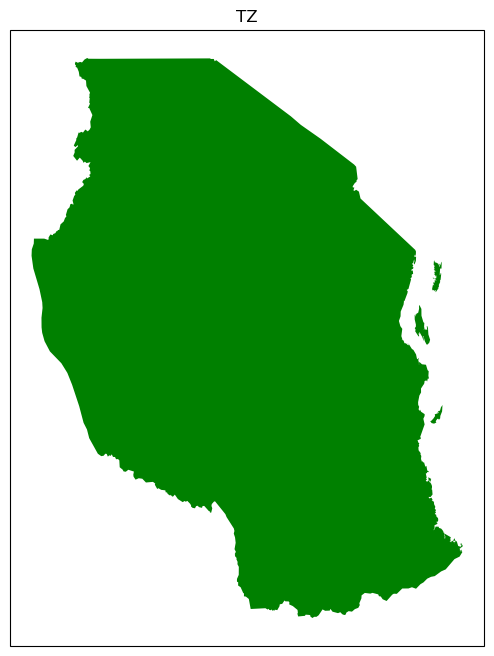

In [5]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
with plt.rc_context({"patch.linewidth": 0.}):
    regions_onshore.plot(
    ax=ax,
    facecolor="green",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
    )
ax.set_title(", ".join(regions_onshore.name.values))

List number of components by type

In [6]:
for c in n.iterate_components(list(n.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name,len(c.df)))

Component 'Bus' has 67 entries
Component 'Carrier' has 16 entries
Component 'Line' has 71 entries
Component 'LineType' has 34 entries
Component 'TransformerType' has 14 entries
Component 'Load' has 67 entries
Component 'Generator' has 263 entries
Component 'StorageUnit' has 16 entries


List the snapshots of the PyPSA network

In [7]:
print(n.snapshots)
print(f"Time steps: " + str(len(n.snapshots)))

DatetimeIndex(['2013-01-01 00:00:00', '2013-01-01 01:00:00',
               '2013-01-01 02:00:00', '2013-01-01 03:00:00',
               '2013-01-01 04:00:00', '2013-01-01 05:00:00',
               '2013-01-01 06:00:00', '2013-01-01 07:00:00',
               '2013-01-01 08:00:00', '2013-01-01 09:00:00',
               ...
               '2013-12-31 14:00:00', '2013-12-31 15:00:00',
               '2013-12-31 16:00:00', '2013-12-31 17:00:00',
               '2013-12-31 18:00:00', '2013-12-31 19:00:00',
               '2013-12-31 20:00:00', '2013-12-31 21:00:00',
               '2013-12-31 22:00:00', '2013-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)
Time steps: 8760


## Analyse energy system

Analyse the current capacity of the energy system - map view

c:\Users\hie\AppData\Local\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



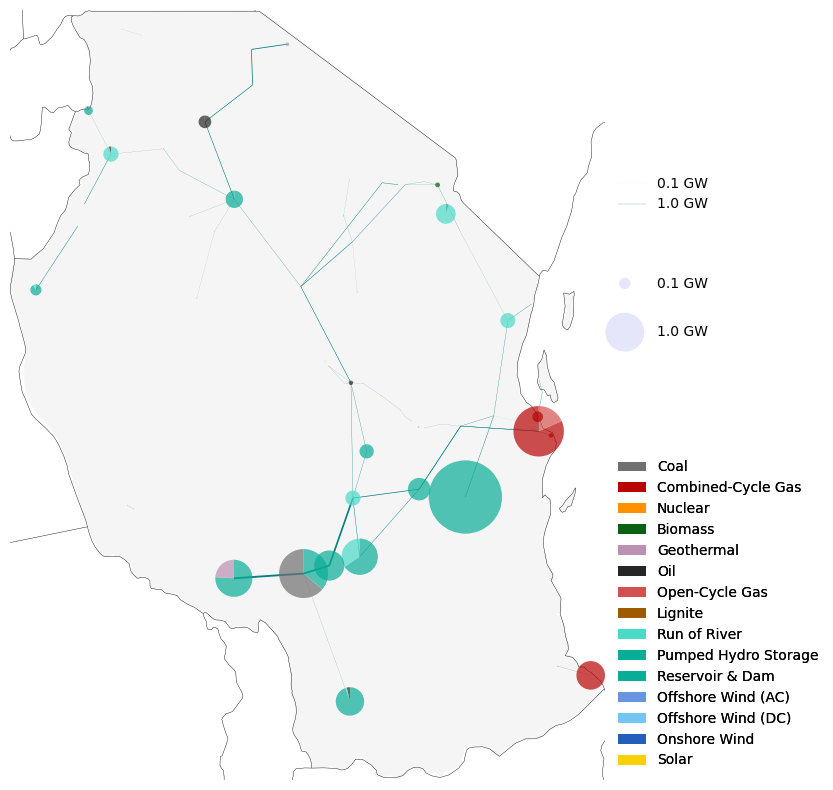

In [8]:
# Scale settings
bus_scale = 6e3 
line_scale = 6e3

# Legend settings
bus_sizes = [100, 1000]  # in MW
line_sizes = [100, 1000]  # in MW

n.carriers.drop("Load", inplace=True)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
gen = n.generators[n.generators.carrier != "load"].groupby(["bus", "carrier"]).p_nom.sum()
sto = n.storage_units.groupby(["bus", "carrier"]).p_nom.sum()
buses = pd.concat([gen, sto])

with plt.rc_context({"patch.linewidth": 0.}):
    n.plot(
        bus_sizes=buses / bus_scale,
        bus_alpha=0.7,
        line_widths=n.lines.s_nom_opt / line_scale,
        link_widths=n.links.p_nom_opt / line_scale,
        line_colors="teal",
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )
regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)
ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])
legend_kwargs = {"loc": "upper left", "frameon": False}
legend_circles_dict = {"bbox_to_anchor": (1, 0.67), "labelspacing": 2.5, **legend_kwargs}

# Add legend circles with custom colors using patch_kw
add_legend_circles(
    ax,
    [s / bus_scale for s in bus_sizes],
    [f"{s / 1000} GW" for s in bus_sizes],
    legend_kw=legend_circles_dict,
    patch_kw={"facecolor": "lavender", "edgecolor": "white"}  # Custom colors
)

add_legend_lines(
    ax,
    [s / line_scale for s in line_sizes],
    [f"{s / 1000} GW" for s in line_sizes],
    legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
   
)
add_legend_patches(
    ax,
    n.carriers.color,
    n.carriers.nice_name,
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc":"lower left"},
)
fig.tight_layout()

Analyse the current generation capacity of the energy system - pie chart view

Text(0.5, 1.0, 'Generator Capacity by Carrier')

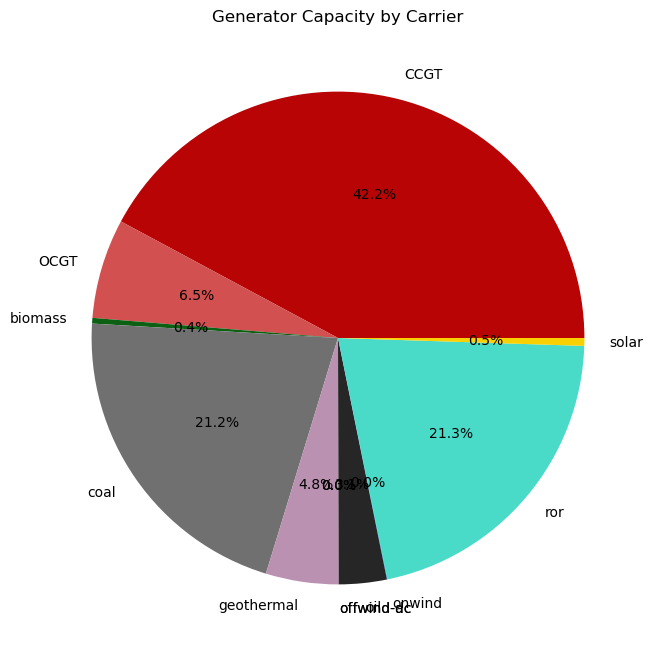

In [9]:
generator_capacity_by_carrier = (
    n.generators[n.generators.carrier != "load"]
    .groupby(["carrier"])
    .p_nom.sum()
)
plt.figure(figsize=(8, 8))
plt.pie(
    generator_capacity_by_carrier,
    labels=generator_capacity_by_carrier.index,
    autopct='%1.1f%%',
    colors=n.carriers[
            n.carriers.index.isin(generator_capacity_by_carrier.index)
        ].color.reindex(generator_capacity_by_carrier.index)
)
plt.title("Generator Capacity by Carrier")

Including storage

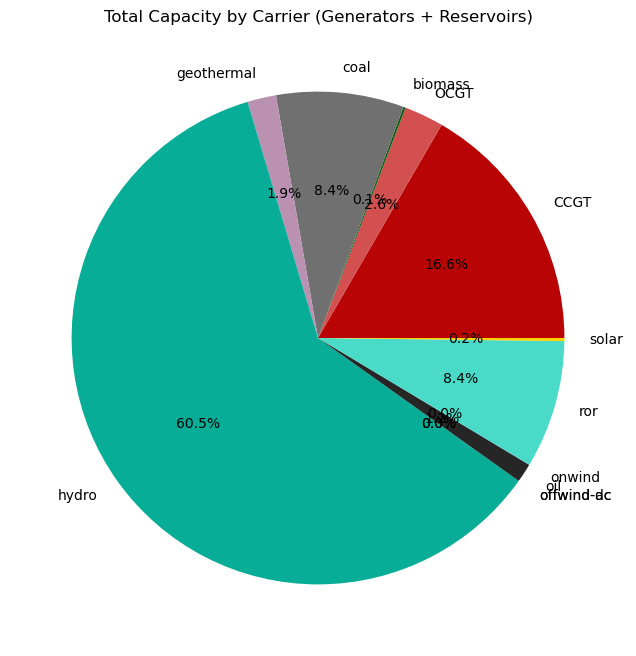

In [10]:
# Combine generator and reservoir capacities
generator_capacity_by_carrier = (
    n.generators[n.generators.carrier != "load"]
    .groupby(["carrier"])
    .p_nom.sum()
)

reservoir_capacity_by_carrier = (
    n.storage_units[n.storage_units.carrier != "load"]
    .groupby(["carrier"])
    .p_nom.sum()
)

# Combine both capacities into a single DataFrame
total_capacity_by_carrier = (
    pd.concat([generator_capacity_by_carrier, reservoir_capacity_by_carrier])
    .groupby(level=0)
    .sum()
)

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    total_capacity_by_carrier,
    labels=total_capacity_by_carrier.index,
    autopct='%1.1f%%',
    colors=n.carriers[
        n.carriers.index.isin(total_capacity_by_carrier.index)
    ].color.reindex(total_capacity_by_carrier.index)
)
plt.title("Total Capacity by Carrier (Generators + Reservoirs)")
plt.show()

Analyse the current gernation capacity of the energy system - tabular view

In [11]:
generator_capacity_by_carrier/1e3 # in GW

carrier
CCGT          1.192700
OCGT          0.185000
biomass       0.010500
coal          0.600000
geothermal    0.135000
offwind-ac    0.000000
offwind-dc    0.000000
oil           0.088800
onwind        0.000911
ror           0.601786
solar         0.014472
Name: p_nom, dtype: float64

In [12]:
total_capacity_by_carrier/1e3 # in GW

carrier
CCGT          1.192700
OCGT          0.185000
biomass       0.010500
coal          0.600000
geothermal    0.135000
hydro         4.340626
offwind-ac    0.000000
offwind-dc    0.000000
oil           0.088800
onwind        0.000911
ror           0.601786
solar         0.014472
Name: p_nom, dtype: float64

Analyse the future capacity of the energy system - map view

c:\Users\hie\AppData\Local\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



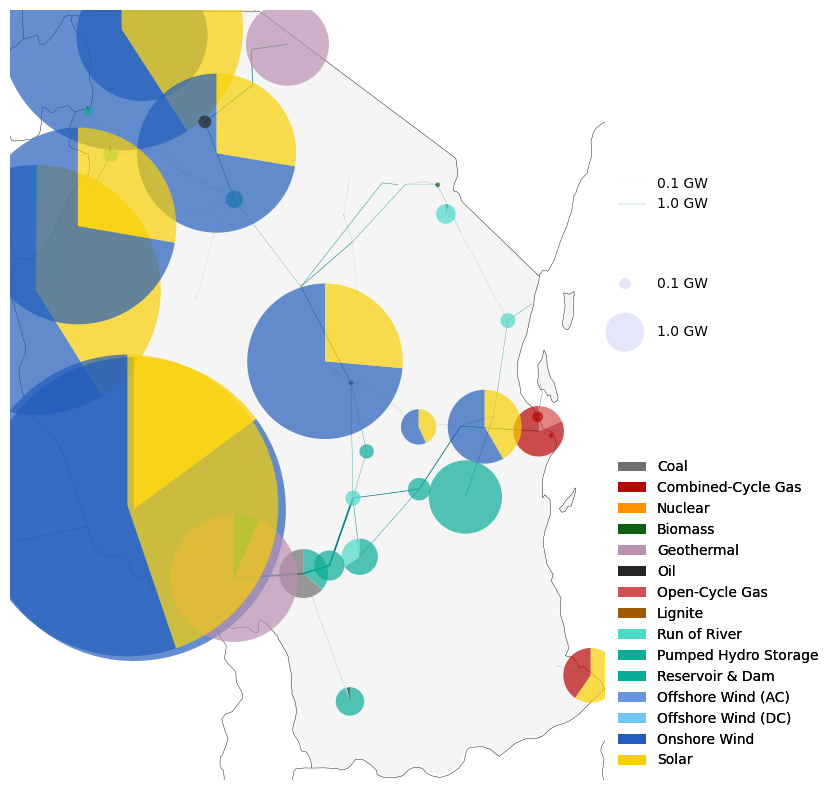

In [13]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
gen = n.generators[n.generators.carrier != "load"].groupby(["bus", "carrier"]).p_nom_opt.sum()
sto = n.storage_units.groupby(["bus", "carrier"]).p_nom_opt.sum()
buses = pd.concat([gen, sto])

with plt.rc_context({"patch.linewidth": 0.}):
    n.plot(
        bus_sizes=buses / bus_scale,
        bus_alpha=0.7,
        line_widths=n.lines.s_nom_opt / line_scale,
        link_widths=n.links.p_nom_opt / line_scale,
        line_colors="teal",
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )
regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)
ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])
legend_kwargs = {"loc": "upper left", "frameon": False}
legend_circles_dict = {"bbox_to_anchor": (1, 0.67), "labelspacing": 2.5, **legend_kwargs}

add_legend_circles(
    ax,
    [s / bus_scale for s in bus_sizes],
    [f"{s / 1000} GW" for s in bus_sizes],
    legend_kw=legend_circles_dict,
    patch_kw={"facecolor": "lavender", "edgecolor": "white"}     
)
add_legend_lines(
    ax,
    [s / line_scale for s in line_sizes],
    [f"{s / 1000} GW" for s in line_sizes],
    legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
    
)
add_legend_patches(
    ax,
    n.carriers.color,
    n.carriers.nice_name,
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc":"lower left"},
)
fig.tight_layout()

Analys the future generation capacity expansion of the energy system - bar chart

<AxesSubplot:title={'center':'Generator capacity expansion in GW'}, xlabel='carrier'>

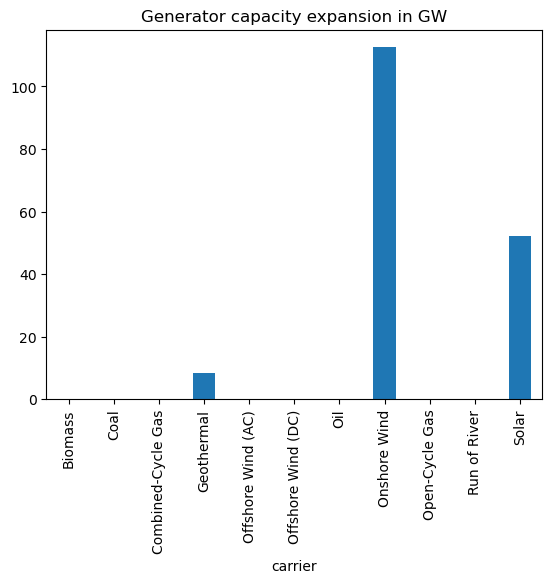

In [14]:
optimal_capacity = n.statistics.optimal_capacity(comps=["Generator"]).droplevel(0).div(1e3)
installed_capacity = n.statistics.installed_capacity(comps=["Generator"]).droplevel(0).div(1e3)
generation_capacity_expansion = optimal_capacity - installed_capacity
generation_capacity_expansion.drop(["load"], inplace=True)
generation_capacity_expansion.plot.bar(title="Generator capacity expansion in GW")

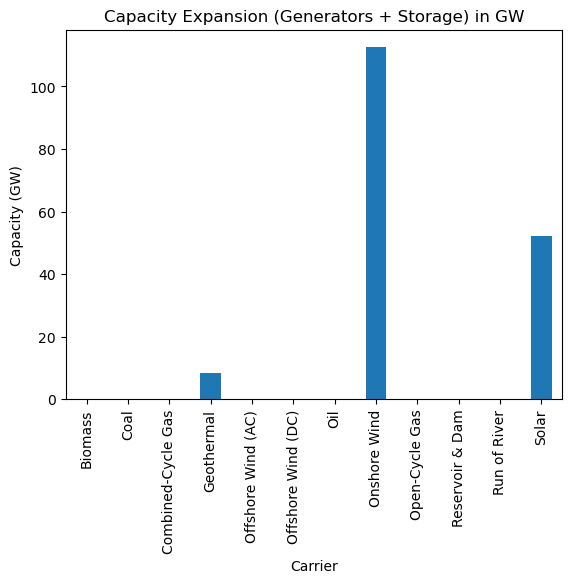

In [15]:
# Calculate optimal and installed capacities for generators
optimal_capacity_generators = n.statistics.optimal_capacity(comps=["Generator"]).droplevel(0).div(1e3)
installed_capacity_generators = n.statistics.installed_capacity(comps=["Generator"]).droplevel(0).div(1e3)

# Calculate optimal and installed capacities for storage units
optimal_capacity_storage = n.statistics.optimal_capacity(comps=["StorageUnit"]).droplevel(0).div(1e3)
installed_capacity_storage = n.statistics.installed_capacity(comps=["StorageUnit"]).droplevel(0).div(1e3)

# Combine generator and storage capacities
optimal_capacity = pd.concat([optimal_capacity_generators, optimal_capacity_storage]).groupby(level=0).sum()
installed_capacity = pd.concat([installed_capacity_generators, installed_capacity_storage]).groupby(level=0).sum()

# Calculate capacity expansion
generation_capacity_expansion = optimal_capacity - installed_capacity
generation_capacity_expansion.drop(["load"], inplace=True, errors="ignore")  # Drop "load" if it exists

# Plot the capacity expansion
generation_capacity_expansion.plot.bar(title="Capacity Expansion (Generators + Storage) in GW")
plt.ylabel("Capacity (GW)")
plt.xlabel("Carrier")
plt.show()

Plot the future generation capacity expansion of the energy system - tabular chart

In [16]:
generation_capacity_expansion # In GW

carrier
Biomass               3.047887e-08
Coal                  2.943830e-09
Combined-Cycle Gas    1.559657e-01
Geothermal            8.564071e+00
Offshore Wind (AC)             NaN
Offshore Wind (DC)             NaN
Oil                   3.097219e-06
Onshore Wind          1.124894e+02
Open-Cycle Gas        8.702508e-07
Reservoir & Dam       0.000000e+00
Run of River          0.000000e+00
Solar                 5.231286e+01
dtype: float64

Analyse the future energy generation of the energy system - bar chart view

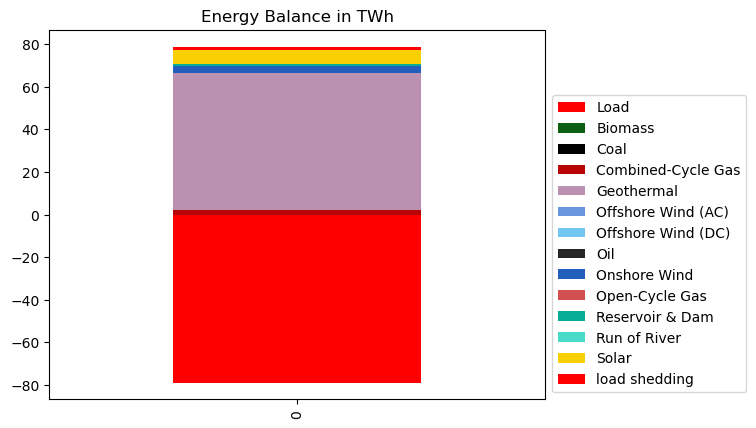

In [17]:
colors = {key.lower(): value.lower() for key, value in config["plotting"]["tech_colors"].items()}
nice_names = {value.lower(): key for key, value in config["plotting"]["nice_names"].items()}

rename_cols = {
    '-': 'Load',
    'load': 'load shedding',
}

energy_balance = (
    n.statistics.energy_balance()
    .loc[:, :, "AC"]
    .groupby("carrier")
    .sum()
    .div(1e6)
    .to_frame()
    .T
    .rename(columns=rename_cols)
)

# color-matching
color_list = []
for col in energy_balance.columns:
    original_name = col.lower()
    key_name = nice_names.get(original_name, original_name)
    color = colors.get(key_name.lower(), 'gray')
    color_list.append(color)


fig, ax = plt.subplots()
energy_balance.plot.bar(stacked=True, ax=ax, title="Energy Balance in TWh", color=color_list)
handles, labels = ax.get_legend_handles_labels()
nice_labels = [config["plotting"]["nice_names"].get(label, label) for label in energy_balance.columns]
ax.legend(handles, nice_labels, bbox_to_anchor=(1, 0), loc="lower left", title=None, ncol=1)

plt.show()

Analyse the future energy generation of the energy system - tabular view

In [18]:
n.statistics.energy_balance()/1e6 # In TWh

component    carrier             bus_carrier
Load         -                   AC            -78.850000
Generator    Biomass             AC              0.009504
             Coal                AC              0.000003
             Combined-Cycle Gas  AC              2.100423
             Geothermal          AC             64.246244
             Offshore Wind (AC)  AC              0.000007
             Offshore Wind (DC)  AC              0.000006
             Oil                 AC              0.001426
             Onshore Wind        AC              3.382542
             Open-Cycle Gas      AC              0.000935
             Run of River        AC              0.136008
             Solar               AC              6.420358
             load                AC              1.674279
StorageUnit  Reservoir & Dam     AC              0.878263
dtype: float64

## Analyse pv and wind potential - map view

In [19]:
solar = xr.open_dataset(solar_path)
wind = xr.open_dataset(onwind_path)

def plot_voronoi(n, carrier, voronoi, cmap, projection, title=None, filename=None):
    g = n.generators.loc[n.generators.carrier == carrier]
    br = gpd.read_file(f"{PARENT}resources/{scenario_name}/bus_regions/regions_{voronoi}.geojson").set_index("name")
    br_area = br.to_crs("ESRI:54009")
    br_area = br_area.geometry.area * 1e-6
    br["p_nom_max"] = g.groupby("bus").sum().p_nom_max / br_area

    fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={"projection": projection})
    plt.rcParams.update({"font.size": 10})
    br.plot(
        ax=ax,
        column="p_nom_max",
        transform=ccrs.PlateCarree(),
        linewidth=0.25,
        edgecolor="k",
        cmap=cmap,
        vmin=0,
        vmax=br["p_nom_max"].max(),
        legend=True,
        legend_kwds={"label": r"potential density"},
    )
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS.with_scale("110m"))
    ax.set_extent(country_coordinates, crs=ccrs.PlateCarree()) 
    
    if title is not None:
        plt.title(title)

C:\Users\hie\AppData\Local\Temp\ipykernel_2756\1178718638.py:4: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



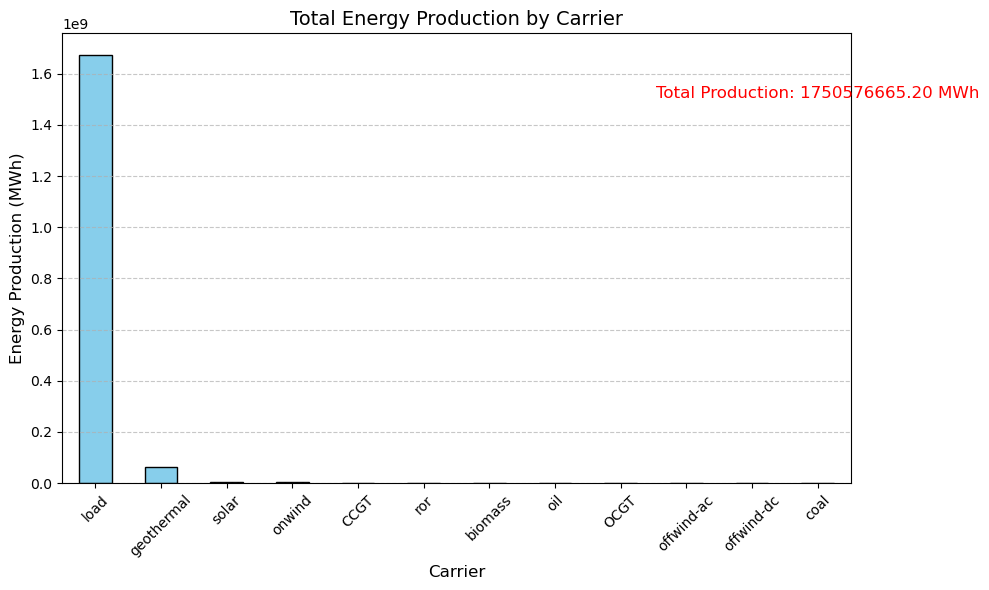

In [20]:
import matplotlib.pyplot as plt

# Group energy production by carrier and sum over all time snapshots
production_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().sum()

# Calculate the total energy production
total_production = production_by_carrier.sum()

# Plot the production by carrier
plt.figure(figsize=(10, 6))
production_by_carrier.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Total Energy Production by Carrier', fontsize=14)
plt.xlabel('Carrier', fontsize=12)
plt.ylabel('Energy Production (MWh)', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate the total production on the plot
plt.text(len(production_by_carrier) - 1, production_by_carrier.max() * 0.9, 
         f'Total Production: {total_production:.2f} MWh', 
         fontsize=12, color='red', ha='center')

plt.tight_layout()
plt.show()

Plot wind energy potential

INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, loads, storage_units, transformers


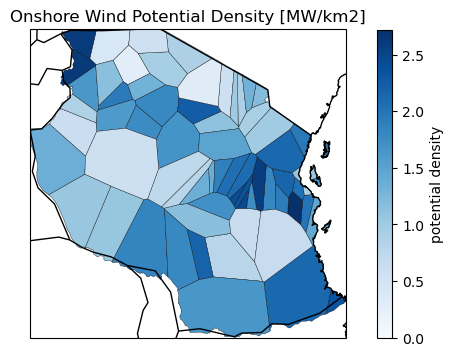

In [21]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plot_voronoi(
    pypsa.Network(network_path),
    "onwind",
    "onshore",
    "Blues",
    ccrs.PlateCarree(),
    title="Onshore Wind Potential Density [MW/km2]",
)
warnings.simplefilter(action='default', category=FutureWarning)

Plot pv energy potential

INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, loads, storage_units, transformers


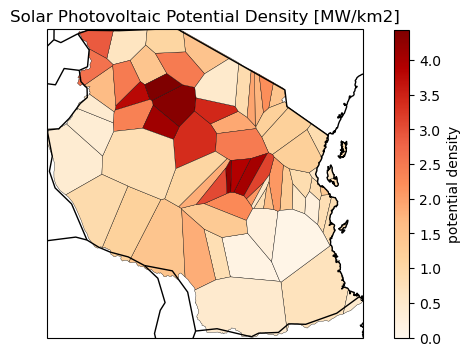

In [22]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plot_voronoi(
    pypsa.Network(network_path),
    "solar",
    "onshore",
    "OrRd",
    ccrs.PlateCarree(),
    title="Solar Photovoltaic Potential Density [MW/km2]",
)
warnings.simplefilter(action='default', category=FutureWarning)

INFO:pypsa.io:Imported network elec_s_all_ec_lcopt_1h.nc has buses, carriers, generators, lines, loads, storage_units


/n=== Transmission Line Summary ===
           length        s_nom
count   71.000000    71.000000
mean   100.223033   458.960775
std     68.255213   442.116502
min      6.815345    53.728216
25%     45.370223   147.466806
50%     88.054249   491.556019
75%    147.809043   491.556019
max    267.416307  1787.476433
/nTotal transmission capacity (AC lines): 32586.21 MVA
Total transmission length: 7115.84 km
/n=== Line Loading Summary ===
Max line loading: 1662.95%
Average line loading: 235.43%


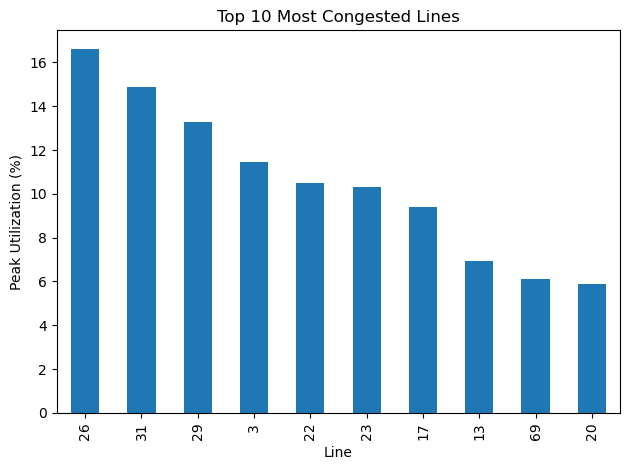

/n=== Line Shadow Prices (if available) ===
Shadow prices not available (run LOPF with duals enabled).
/n=== Approximate Line Losses ===
Total transmission losses over the modelled period: 0.00 MWh


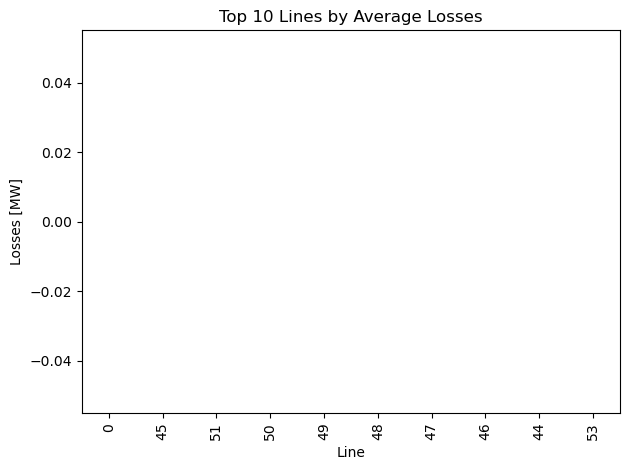

/n=== Impedance Parameters (r, x, type) ===
               r           x
count  71.000000   71.000000
mean   18.198496  149.227671
std    17.331433  142.117747
min     0.966756    7.927396
25%     5.924741   48.582873
50%    14.237949  116.751184
75%    22.561811  185.006851
max    85.493122  701.043598
/n=== Unserved Load due to Grid Constraints ===
Total unserved load (due to congestion or generation limits): 0.00 MWh


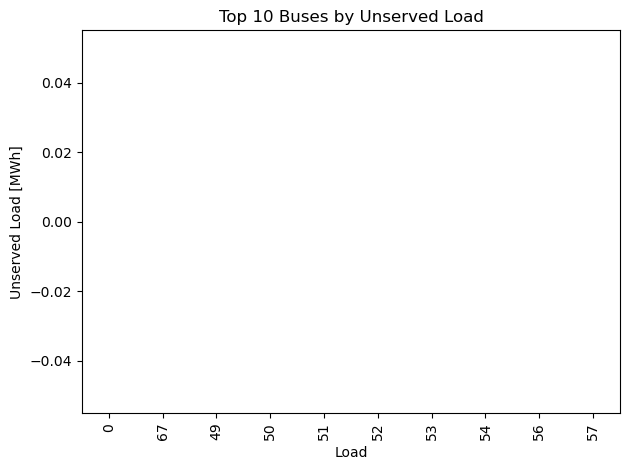

/n=== Congestion vs. Unserved Load Correlation ===


NameError: name 'congestion_index' is not defined

In [23]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt

# Load the network
n = pypsa.Network("C:/Users/hie/pe_tan/pypsa-earth/results/2040_base/networks/elec_s_all_ec_lcopt_1h.nc")  # or your relevant .nc file





# ----------------------------
# Basic Transmission Overview
# ----------------------------
print("/n=== Transmission Line Summary ===")
print(n.lines[["bus0", "bus1", "length", "s_nom"]].describe())

# Total line capacity
total_capacity = n.lines.s_nom.sum()
print(f"/nTotal transmission capacity (AC lines): {total_capacity:.2f} MVA")

# Total length
total_length = n.lines.length.sum()
print(f"Total transmission length: {total_length:.2f} km")

# ----------------------------
# Loading Analysis
# ----------------------------
line_loading = abs(n.lines_t.p0) / n.lines.s_nom  # Utilization ratio
max_loading = line_loading.max()
avg_loading = line_loading.mean()
print("/n=== Line Loading Summary ===")
print(f"Max line loading: {max_loading.max():.2%}")
print(f"Average line loading: {avg_loading.mean():.2%}")

# Plot top 10 most congested lines
top_congested = line_loading.max().sort_values(ascending=False).head(10)
top_congested.plot(kind='bar', title='Top 10 Most Congested Lines')
plt.ylabel("Peak Utilization (%)")
plt.tight_layout()
plt.show()

# ----------------------------
# Shadow Prices (Marginal Values)
# ----------------------------
print("/n=== Line Shadow Prices (if available) ===")
if hasattr(n, "line_constraints_dual"):
    shadow_prices = n.line_constraints_dual  # dual prices on thermal limits
    print(shadow_prices.describe())
else:
    print("Shadow prices not available (run LOPF with duals enabled).")

# ----------------------------
# Line Losses
# ----------------------------
print("/n=== Approximate Line Losses ===")
losses = abs(n.lines_t.p0 + n.lines_t.p1)  # p0 + p1 ≈ line loss
total_losses = losses.sum().sum()
print(f"Total transmission losses over the modelled period: {total_losses:.2f} MWh")

# Plot average losses by line
avg_losses = losses.mean().sort_values(ascending=False).head(10)
avg_losses.plot(kind="bar", title="Top 10 Lines by Average Losses")
plt.ylabel("Losses [MW]")
plt.tight_layout()
plt.show()

# ----------------------------
# Electrical Parameters
# ----------------------------
print("/n=== Impedance Parameters (r, x, type) ===")
print(n.lines[["r", "x", "type"]].describe())

# ----------------------------
# Load Shedding due to Constraints
# ----------------------------
print("/n=== Unserved Load due to Grid Constraints ===")
load_diff = n.loads_t.p_set - n.loads_t.p
total_unserved = load_diff.clip(lower=0).sum().sum()
print(f"Total unserved load (due to congestion or generation limits): {total_unserved:.2f} MWh")

# Plot buses with most lost load
lost_load_by_bus = load_diff.clip(lower=0).sum(axis=0).sort_values(ascending=False).head(10)
lost_load_by_bus.plot(kind="bar", title="Top 10 Buses by Unserved Load")
plt.ylabel("Unserved Load [MWh]")
plt.tight_layout()
plt.show()

# ----------------------------
# Correlation Between Congestion and Unserved Load
# ----------------------------
print("/n=== Congestion vs. Unserved Load Correlation ===")
# Ensure bus_congestion has default values for all buses
bus_congestion = pd.Series(0, index=n.buses.index, dtype=float)

# Assign congestion to buses (rough proxy)
for line in congestion_index.index:
    b0 = n.lines.at[line, "bus0"]
    b1 = n.lines.at[line, "bus1"]
    value = congestion_index[line]
    bus_congestion[b0] = max(bus_congestion[b0], value)
    bus_congestion[b1] = max(bus_congestion[b1], value)

# Merge and correlate
merged = pd.DataFrame({
    "lost_load": lost_load_by_bus,
    "max_congestion": bus_congestion.reindex(lost_load_by_bus.index, fill_value=0)  # Handle missing indices
})

print(merged.corr())

# Optional scatter plot
merged.plot.scatter(x="max_congestion", y="lost_load", title="Congestion vs Lost Load")
plt.tight_layout()
plt.show()





# --- Step 1: Estimate Losses on Each Line Using I²R ---

# Line resistance
r = n.lines["r"]

# Nominal voltage per line (get from bus0)
v_nom = n.buses.loc[n.lines["bus0"], "v_nom"]  # in kV
v_nom = v_nom.astype(float) * 1e3  # convert to Volts

# Handle duplicate indices in v_nom by taking the first value
v_nom = v_nom.groupby(v_nom.index).transform("first")

# Power flow (MW) from bus0
p0 = n.lines_t.p0  # MW

# Ensure v_nom aligns with p0
v_nom = v_nom.reindex(p0.columns)

# Estimate current (I = P / V) → then I² * R losses
# Convert MW to W: p0 * 1e6
# losses = (P^2 * R) / V^2  [per line per timestep]
losses = (p0 ** 2).multiply(r, axis=1).divide(v_nom ** 2, axis=1)  # in MW

# --- Step 2: Total Losses ---
total_loss_mwh = losses.sum().sum()
print(f"Estimated total I²R transmission losses: {total_loss_mwh:.2f} MWh")

# --- Step 3: Average Loss Per Line ---
avg_loss_per_line = losses.mean().sort_values(ascending=False)
avg_loss_per_line.name = "avg_loss_mw"

# Combine with line metadata
line_info = n.lines[["bus0", "bus1", "length", "s_nom"]].copy()
line_info["avg_loss_mw"] = avg_loss_per_line
line_info["total_loss_mwh"] = losses.sum()

# --- Step 4: Export to CSV ---
line_info.to_csv("line_losses_estimated.csv")
print("Line-level loss estimates exported to: line_losses_estimated.csv")

# --- Optional: Display Top Lossy Lines ---
print("\nTop 10 lines by average loss [MW]:")
print(line_info.sort_values(by="avg_loss_mw", ascending=False).head(10))
